# Importing Relevant Libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pylab as pylab
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Setting Default Parameters

We set here the deafault size of the plot figures in our analysis.

In [51]:
pylab.rcParams['figure.figsize'] = (15, 8)
# pylab.rcParams['figure.figsize'] = (12, 7)
pylab.rcParams['axes.titlesize'] = 24.0
pylab.rcParams['xtick.labelsize'] = 22.0
pylab.rcParams['ytick.labelsize'] = 22.0
pylab.rcParams['legend.fontsize'] = 23.0
pylab.rcParams['axes.labelsize'] = 23.0
pylab.rcParams['mathtext.fontset'] = 'stix'
pylab.rcParams['font.family'] = 'STIXGeneral'

# Reading the Data

We begin our analysis by reading the Future Contracts Price data from a CSV file into a [Pandas Dataframe](https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html#dataframe). We specify that the column `Date` will be the index of the data with the parameter `index_col`.

In [9]:
df = pd.read_csv("../data/CHRIS-LIFFE_C1.csv", index_col=0)

The data being processed is the ICE Europe or LIFFE for the Front Month.

## Data Index

Let's check the index of our data.

In [10]:
df.index

Index(['2019-03-27', '2019-03-26', '2019-03-25', '2019-03-22', '2019-03-21',
       '2019-03-20', '2019-03-19', '2019-03-18', '2019-03-15', '2019-03-14',
       ...
       '1993-09-14', '1993-09-13', '1993-09-10', '1993-09-09', '1993-09-08',
       '1993-09-07', '1993-09-06', '1993-09-03', '1993-09-02', '1993-09-01'],
      dtype='object', name='Date', length=6590)

Pandas correctly set the values of the `Date` column to the `Index` of our Dataframe, but it automatically assigned the datatype of the 'Index' to the 'object' type. Given that we are dealing with a Time Series task, the Index should be set to the correct `datetime64[ns]` data type . Therefore, we use the method `astype` to do the data type conversion.

In [11]:
df.index = df.index.astype('datetime64[ns]')

We check again the index after the conversion.

In [12]:
df.index

DatetimeIndex(['2019-03-27', '2019-03-26', '2019-03-25', '2019-03-22',
               '2019-03-21', '2019-03-20', '2019-03-19', '2019-03-18',
               '2019-03-15', '2019-03-14',
               ...
               '1993-09-14', '1993-09-13', '1993-09-10', '1993-09-09',
               '1993-09-08', '1993-09-07', '1993-09-06', '1993-09-03',
               '1993-09-02', '1993-09-01'],
              dtype='datetime64[ns]', name='Date', length=6590, freq=None)

Now we have the index in the desired `dtype`.

## First and Last Columns

After importing the data to a Pandas Dataframe, we check the first and last columns of our dataset to get a first a glimpse of the data structure.

For getting the first rows, we use the method [head](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) in the previously imported dataframe.

In [7]:
df.head()

,Open,High,Low,Settle,Volume,Prev. Day Open Interest
Date,,,,,,
2019-03-27,1683.0,1696.0,1670.0,1691.0,9042.0,67981.0
2019-03-26,1678.0,1698.0,1669.0,1687.0,6700.0,68955.0
2019-03-25,1630.0,1685.0,1619.0,1677.0,10667.0,68964.0
2019-03-22,1619.0,1637.0,1611.0,1628.0,10989.0,69738.0
2019-03-21,1616.0,1622.0,1609.0,1620.0,9077.0,69665.0


Using the same logic to get the last rows, we use the method [tail](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html).

In [8]:
df.tail()

,Open,High,Low,Settle,Volume,Prev. Day Open Interest
Date,,,,,,
1993-09-07,785.0,796.0,782.0,796.0,324.0,864.0
1993-09-06,790.0,790.0,778.0,784.0,1927.0,2697.0
1993-09-03,790.0,798.0,788.0,793.0,610.0,7218.0
1993-09-02,789.0,793.0,787.0,791.0,245.0,6688.0
1993-09-01,797.0,800.0,793.0,796.0,180.0,6988.0


And now we check the dimensions of our dataframe by invoking the attribute `shape` of our dataframe.

In [9]:
df.shape

(6590, 6)

We have 6590 rows and 6 columns or 6590 days and 6 determinants.

# Sorting the Data Index

As we noticed by the first glimpse in our data, the index `Date` is sorted in descending order with most recent days appearing first. Let's resort our dataset in ascending order to facilitate some data manipulations that will follow in our analysis.

In [13]:
df.sort_index(inplace=True)

Checking again first rows of the data after the resort.

In [11]:
df.head()

,Open,High,Low,Settle,Volume,Prev. Day Open Interest
Date,,,,,,
1993-09-01,797.0,800.0,793.0,796.0,180.0,6988.0
1993-09-02,789.0,793.0,787.0,791.0,245.0,6688.0
1993-09-03,790.0,798.0,788.0,793.0,610.0,7218.0
1993-09-06,790.0,790.0,778.0,784.0,1927.0,2697.0
1993-09-07,785.0,796.0,782.0,796.0,324.0,864.0


# Visualizing the Settle Price

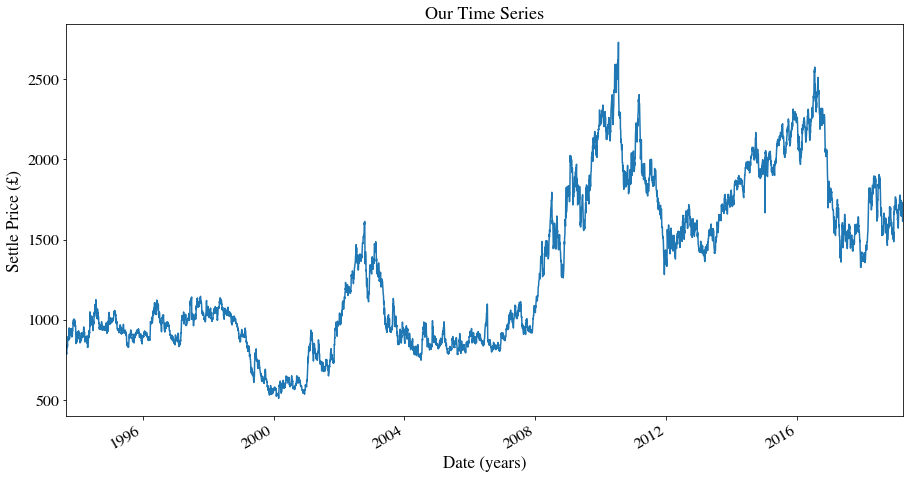

In [43]:
plt.title("Our Time Series")
df["Settle"].plot()
plt.ylabel(r"Settle Price (£)")
plt.xlabel("Date (years)");

Visually we notice that the mean is not constant over time. Thus, this time series is non-stationary.

# Checking the Stationarity Visually

Let's break quartely and then calculate the mean and variance over these periods.

## Breaking the Data in Quarters

First we begin by assigning to the variables `start_date` and `end_date` the date of the first and last data point, respectively. Using the [iloc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html) command, we can retrieve from the Dataframe row according to the interger location specified in the `iloc` argument.

For instance, to get the first row in a Dataframe, one has to use `.iloc[0]` like we do in the following code cell.

In [13]:
start_date = df.iloc[0].name
start_date

Timestamp('1993-09-01 00:00:00')

On the other hand, to get the last row in a Dataframe, one has to use `.iloc[-1]` like we do in the following code cell.

In [14]:
end_date = df.iloc[-1].name
end_date

Timestamp('2019-03-27 00:00:00')

Now we get the initial date of all quarters during the entire time series. For this purpose, we use the `pandas` function `pd.date_range`, which allows us to slice the Dataframe in different intervals. For the `freq` parameter, we use the string `QS`, which means the start of a quarter. More aliases for the `freq` can be found [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases).

In [15]:
date_range = pd.date_range(start=start_date, end=end_date, freq='QS')
date_range

DatetimeIndex(['1993-10-01', '1994-01-01', '1994-04-01', '1994-07-01',
               '1994-10-01', '1995-01-01', '1995-04-01', '1995-07-01',
               '1995-10-01', '1996-01-01',
               ...
               '2016-10-01', '2017-01-01', '2017-04-01', '2017-07-01',
               '2017-10-01', '2018-01-01', '2018-04-01', '2018-07-01',
               '2018-10-01', '2019-01-01'],
              dtype='datetime64[ns]', length=102, freq='QS-JAN')

## Calculating the Quarterly Mean

For each quarter obtained previously, we calculate the respective mean and store them in the new column `Quaterly Mean Settle Price`.

In [16]:
for i in range(len(date_range)-1):
    df.loc[date_range[i]:date_range[i+1], "Quaterly Mean Settle Price"] = \
        df.loc[date_range[i]:date_range[i+1], "Settle"].mean()

## Calculating the Quartely Variance

We do the same for the variance storing it in the column `Quaterly Variance Settle Price`.

In [17]:
for i in range(len(date_range)-1):
    df.loc[date_range[i]:date_range[i+1], "Quaterly Variance Settle Price"] = \
        df.loc[date_range[i]:date_range[i+1], "Settle"].var()

## Calculating the Standard Deviation

And finally for the standard deviation, we have the new column `Quaterly Std Settle Price`.

In [18]:
for i in range(len(date_range)-1):
    df.loc[date_range[i]:date_range[i+1], "Quaterly Std Settle Price"] = \
        df.loc[date_range[i]:date_range[i+1], "Settle"].std()

## Plotting the Mean and Standard Deviation

Now we plot the results obtained and we compare with the original time series.

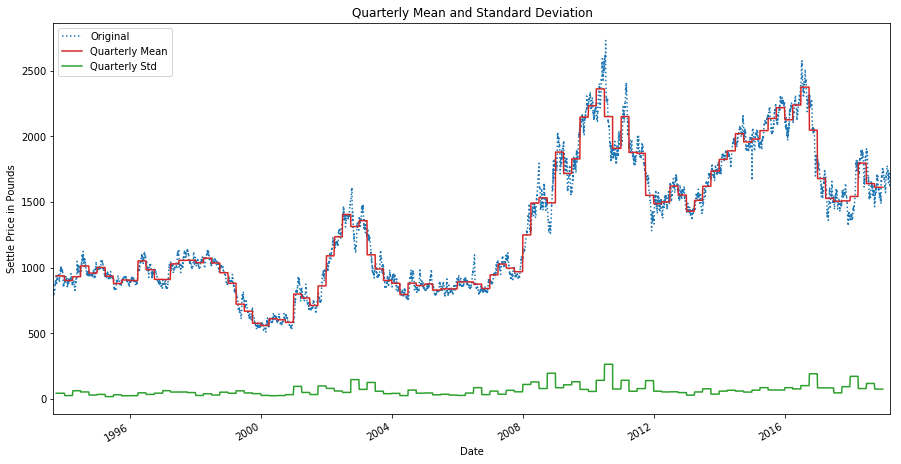

In [19]:
plt.title("Quarterly Mean and Standard Deviation")
df["Settle"].plot(style=":", label="Original")
df["Quaterly Mean Settle Price"].plot(color="C3", label="Quarterly Mean")
df["Quaterly Std Settle Price"].plot(color="C2", label="Quarterly Std")
plt.ylabel("Settle Price in Pounds")
plt.legend();

We clearly see that this time series is non-stationary as the mean is not constant over time.

## Plotting Boxplots for each Month

First let's check for missing values in the `Settle` price per month.

In [20]:
print("------------------------------------")
for month in range(1, 13):
    print("Count of missing values for month", month)
    print(pd.isnull(df[df.index.month==month]["Settle"]).sum())
    print("------------------------------------")

------------------------------------
Count of missing values for month 1
0
------------------------------------
Count of missing values for month 2
0
------------------------------------
Count of missing values for month 3
1
------------------------------------
Count of missing values for month 4
0
------------------------------------
Count of missing values for month 5
0
------------------------------------
Count of missing values for month 6
0
------------------------------------
Count of missing values for month 7
0
------------------------------------
Count of missing values for month 8
0
------------------------------------
Count of missing values for month 9
0
------------------------------------
Count of missing values for month 10
0
------------------------------------
Count of missing values for month 11
0
------------------------------------
Count of missing values for month 12
0
------------------------------------


Let's check for possible Seasonality by plotting boxplots for each month. We have to drop missing values so `Matplotlib` can render the boxplot. We do that by using the method [dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) on each monthly series.

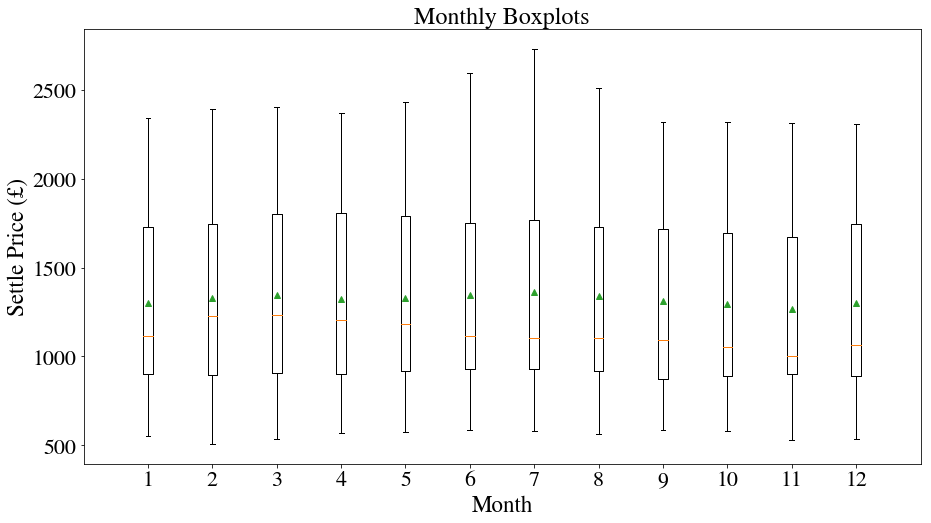

In [52]:
plt.title("Monthly Boxplots")
for month in range(1, 13):
    plt.boxplot(df[df.index.month==month]["Settle"].dropna(), positions=[month], showmeans=True)
    plt.xticks(ticks=range(1, 13), labels=range(1, 13))
    plt.ylabel("Settle Price (£)")
    plt.xlabel("Month")
    plt.xlim(0, 13)

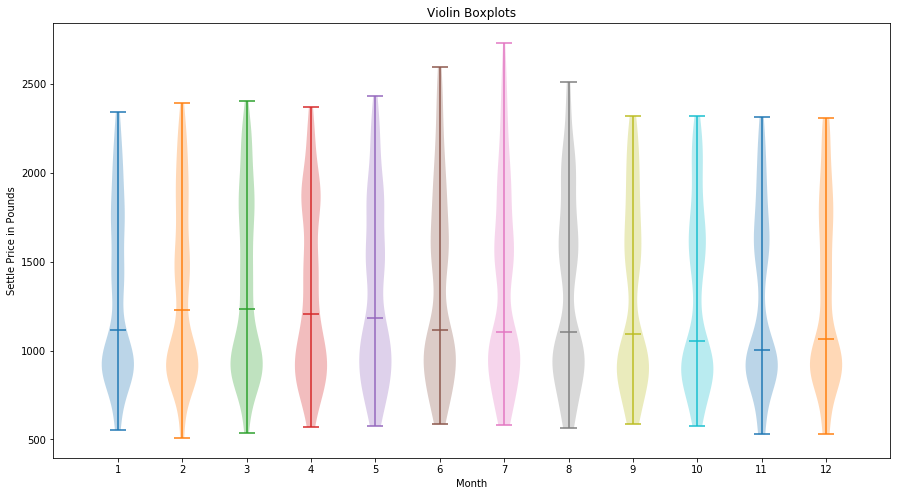

In [22]:
plt.title("Violin Boxplots")
for month in range(1, 13):
    plt.violinplot(df[df.index.month==month]["Settle"].dropna(), positions=[month], showmedians=True)
    plt.xticks(ticks=range(1, 13), labels=range(1, 13))
    plt.ylabel("Settle Price in Pounds")
    plt.xlabel("Month")
    plt.xlim(0, 13)

Now we check the variance.

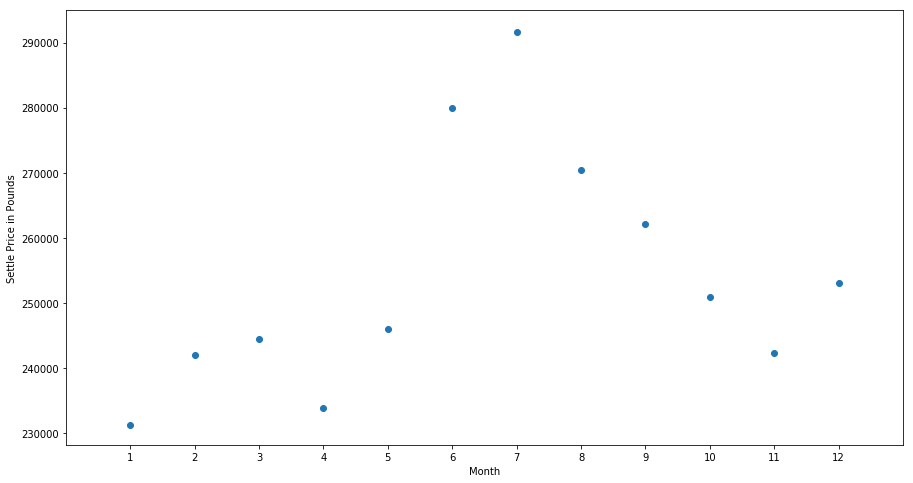

In [23]:
for month in range(1, 13):
    plt.scatter(month, df[df.index.month==month]["Settle"].dropna().var(), color="C0")
    plt.xticks(ticks=range(1, 13), labels=range(1, 13))
    plt.ylabel("Settle Price in Pounds")
    plt.xlabel("Month")
    plt.xlim(0, 13)

## Plotting Boxplots for Each Day of the Week

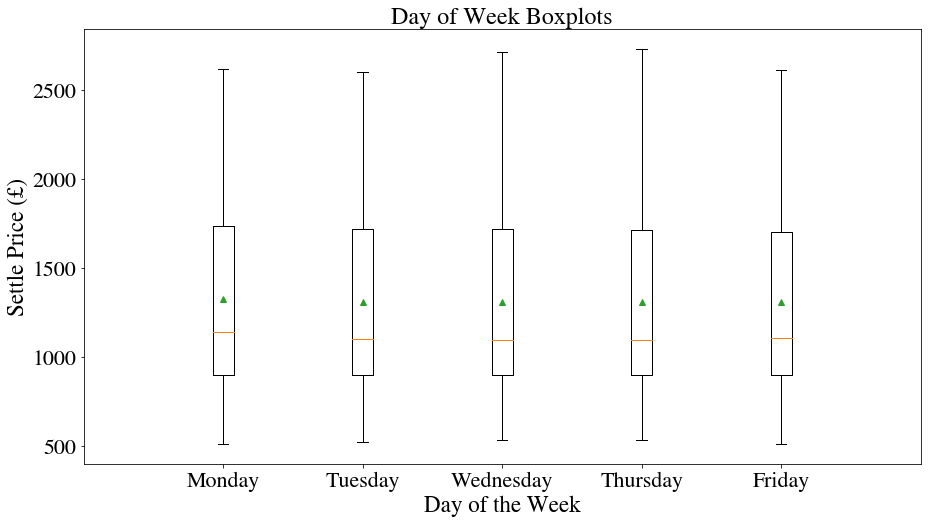

In [55]:
plt.title("Day of Week Boxplots")
for dayofweek in range(0, 5):
    plt.boxplot(df[df.index.dayofweek==dayofweek]["Settle"].dropna(), positions=[dayofweek], showmeans=True)
    plt.xticks(ticks=range(0, 5), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])
    plt.ylabel("Settle Price (£)")
    plt.xlabel("Day of the Week")
    plt.xlim(-1, 5)

There is a slight increase in the median during the months of February, March and April. However, the mean, indicated by the green in arrow in the boxplots, remains almost constant during all months. This way, we can conclude visually that the time series does not present a heavy monthly seasonality factor.

Now we check the variance.

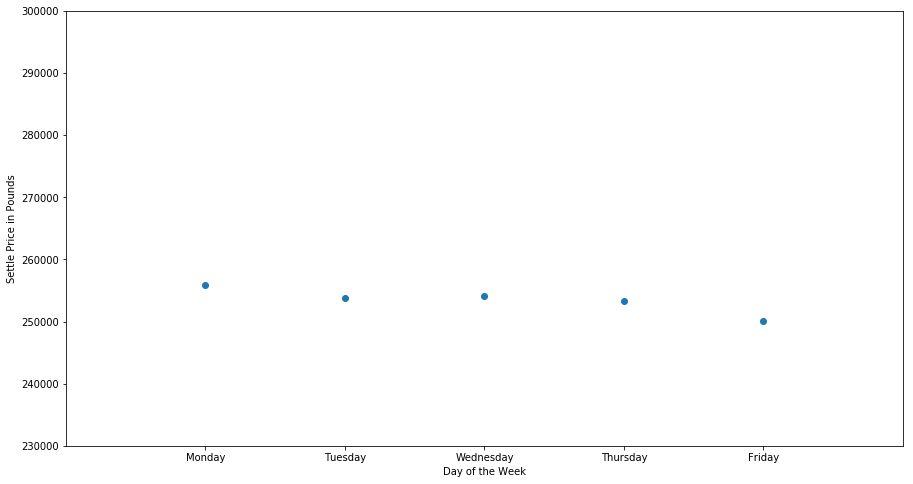

In [25]:
for dayofweek in range(0, 5):
    plt.scatter(dayofweek, df[df.index.dayofweek==dayofweek]["Settle"].dropna().var(), color="C0")
    plt.xticks(ticks=range(0, 5), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])
    plt.ylabel("Settle Price in Pounds")
    plt.xlabel("Day of the Week")
    plt.xlim(-1, 5)
    plt.ylim(230000, 300000)

## Plotting Boxplots for Quarters

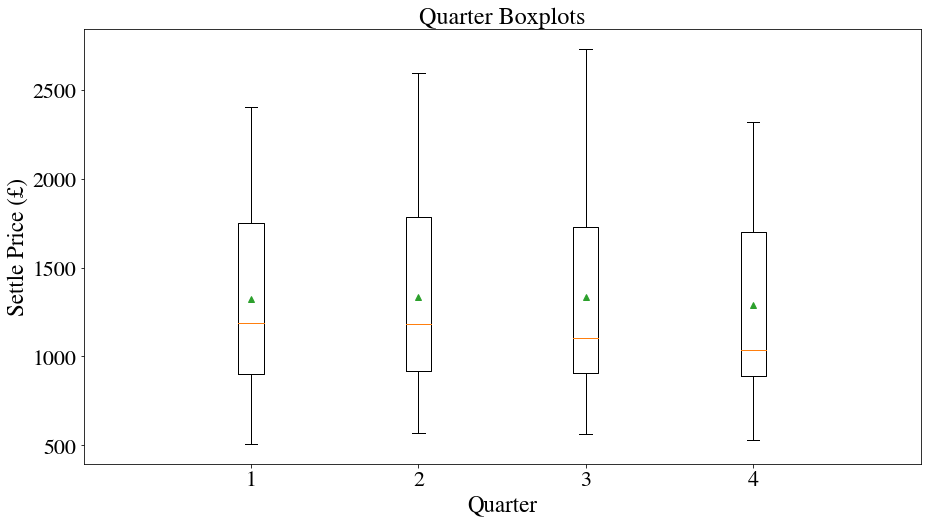

In [53]:
plt.title("Quarter Boxplots")
for quarter in range(1, 5):
    plt.boxplot(df[df.index.quarter==quarter]["Settle"].dropna(), positions=[quarter], showmeans=True)
    plt.xticks(ticks=range(1, 5), labels=range(1, 5))
    plt.ylabel("Settle Price (£)")
    plt.xlabel("Quarter")
    plt.xlim(0, 5)

Now we check the variance.

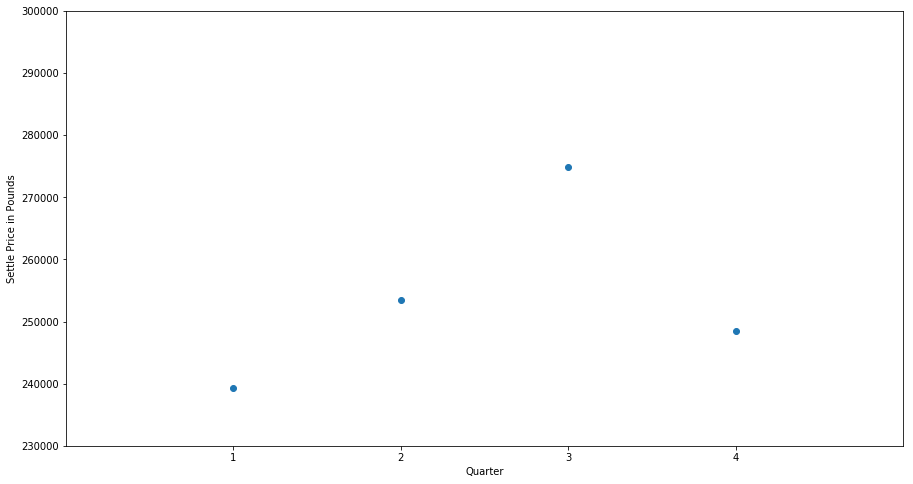

In [27]:
for quarter in range(1, 5):
    plt.scatter(quarter, df[df.index.quarter==quarter]["Settle"].dropna().var(), color="C0")
    plt.xticks(ticks=range(1, 5), labels=range(1, 5))
    plt.ylabel("Settle Price in Pounds")
    plt.xlabel("Quarter")
    plt.xlim(0, 5)
    plt.ylim(230000, 300000)

## Plotting the Boxplots for Week of Year

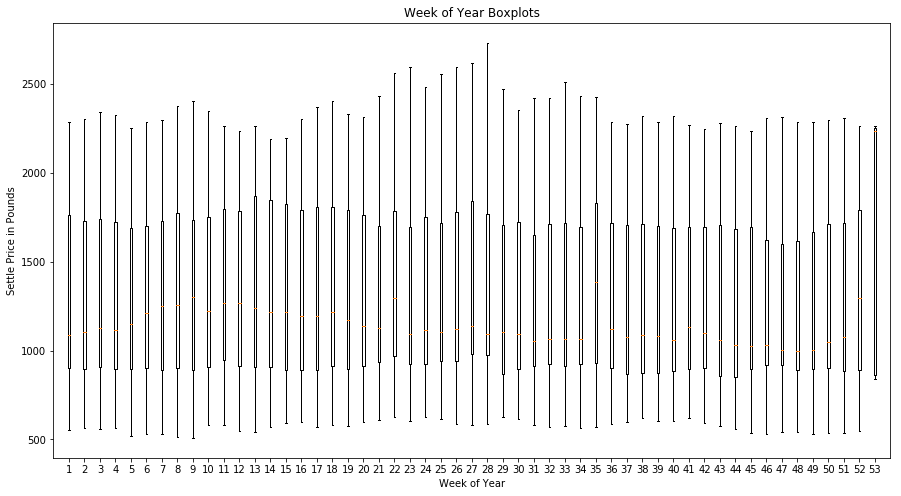

In [28]:
max_nbr_weeks = max(df.index.weekofyear)

plt.title("Week of Year Boxplots")
for weekofyear in range(1, max_nbr_weeks+1):
    plt.boxplot(df[df.index.weekofyear==weekofyear]["Settle"].dropna(), positions=[weekofyear], showmeans=False)
    plt.xticks(ticks=range(1, max_nbr_weeks+1), labels=range(1, max_nbr_weeks+1))
    plt.ylabel("Settle Price in Pounds")
    plt.xlabel("Week of Year")
    plt.xlim(0, max_nbr_weeks+1)

Check the variance.

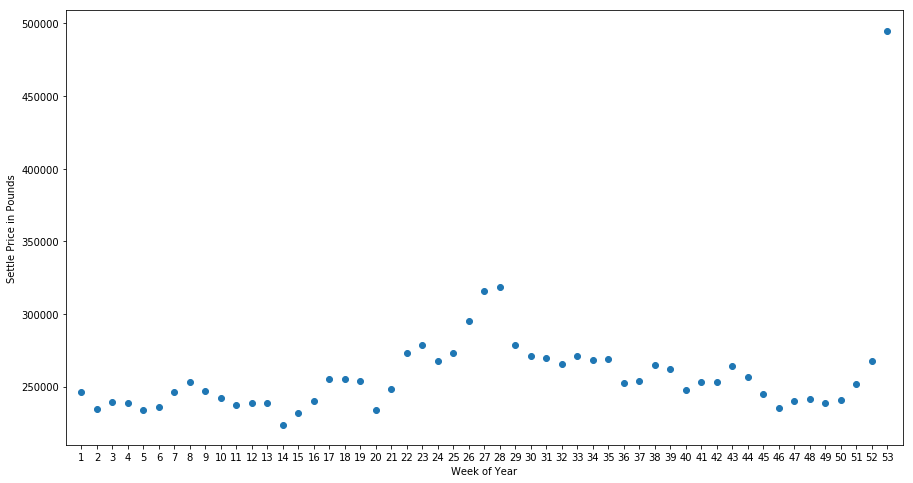

In [29]:
for weekofyear in range(1, max_nbr_weeks+1):
    plt.scatter(weekofyear, df[df.index.weekofyear==weekofyear]["Settle"].dropna().var(), color="C0")
    plt.xticks(ticks=range(1, max_nbr_weeks+1), labels=range(1, max_nbr_weeks+1))
    plt.ylabel("Settle Price in Pounds")
    plt.xlabel("Week of Year")
    plt.xlim(0, max_nbr_weeks+1)

## Plotting the Boxplots for Day of Month

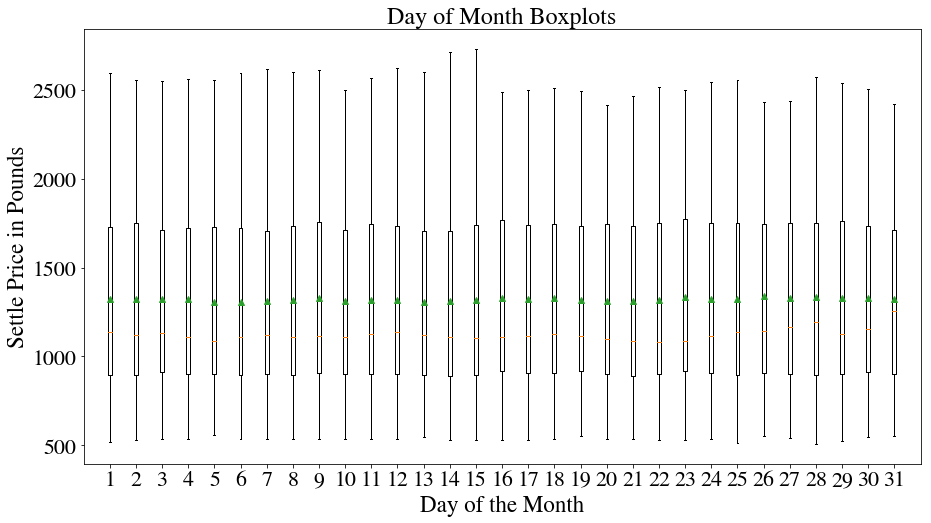

In [54]:
plt.title("Day of Month Boxplots")
for day in range(1, 32):
    plt.boxplot(df[df.index.day==day]["Settle"].dropna(), positions=[day], showmeans=True)
    plt.xticks(ticks=range(1, 32), labels=range(1, 32))
    plt.ylabel("Settle Price in Pounds")
    plt.xlabel("Day of the Month")
    plt.xlim(0, 32)

Check the variance.

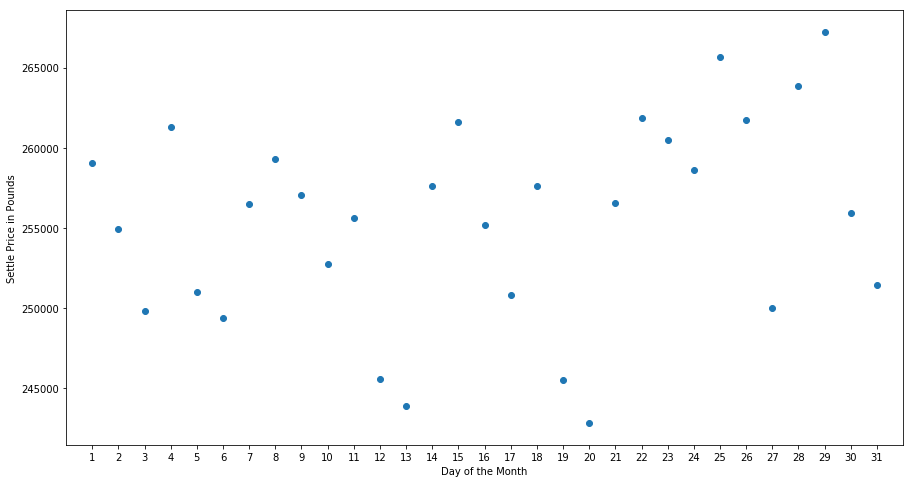

In [31]:
for day in range(1, 32):
    plt.scatter(day, df[df.index.day==day]["Settle"].dropna().var(), color="C0")
    plt.xticks(ticks=range(1, 32), labels=range(1, 32))
    plt.ylabel("Settle Price in Pounds")
    plt.xlabel("Day of the Month")
    plt.xlim(0, 32)
#     plt.ylim(230000, 300000)

Line plot for the variance.

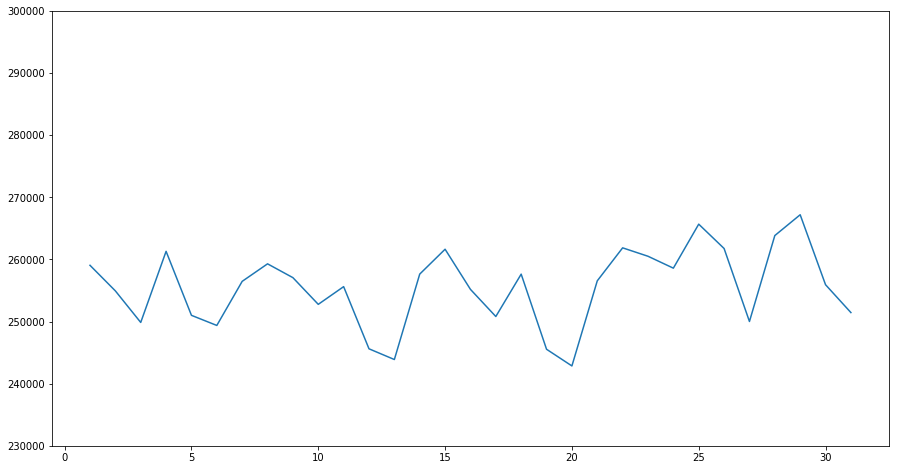

In [32]:
days_vars = []
for day in range(1, 32):
    days_vars.append(df[df.index.day==day]["Settle"].dropna().var())

plt.plot(range(1, 32), days_vars)
plt.ylim(230000, 300000);

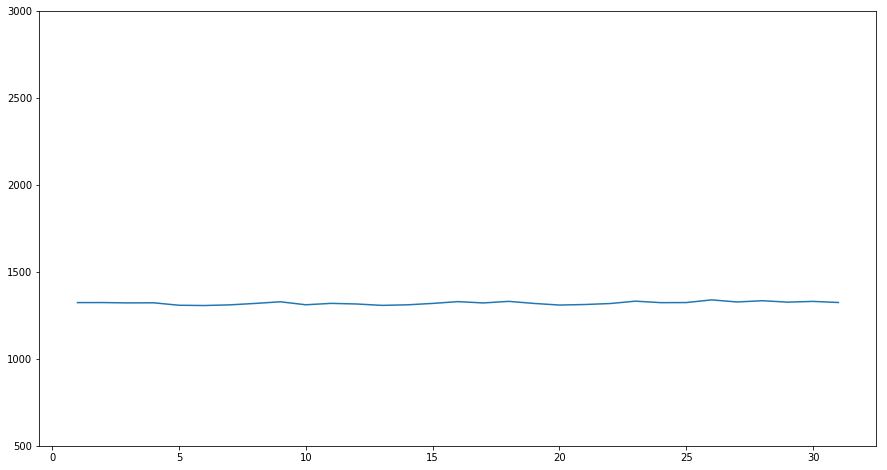

In [33]:
days_means = []
for day in range(1, 32):
    days_means.append(df[df.index.day==day]["Settle"].dropna().mean())

plt.plot(range(1, 32), days_means)
plt.ylim(500, 3000);

# Checking the Autocorrelation

To check the autocorrelation in our time series, we use the function `plot_acf` of the package `statsmodels`.

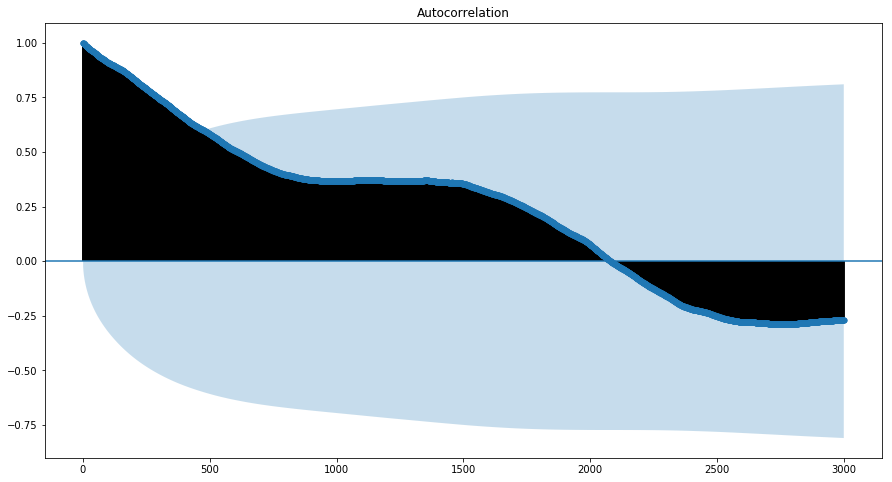

In [18]:
plot_acf(df["Settle"].dropna(), lags=3000);

The function is working properly.

# Checking the Partial Correlation

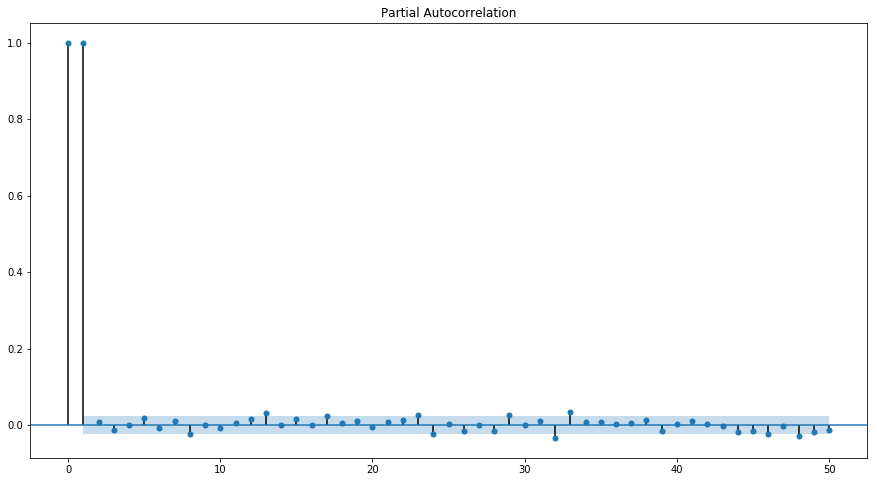

In [35]:
plot_pacf(df["Settle"].dropna(), lags=50);

# Eliminating the Trend

## Moving Average

We calculate the moving average by using the `Pandas` function `rolling`.

In [335]:
moving_avg_90days = df["Settle"].dropna().rolling(90).mean()
moving_avg_180days = df["Settle"].dropna().rolling(180).mean()
moving_avg_365days = df["Settle"].dropna().rolling(365).mean()

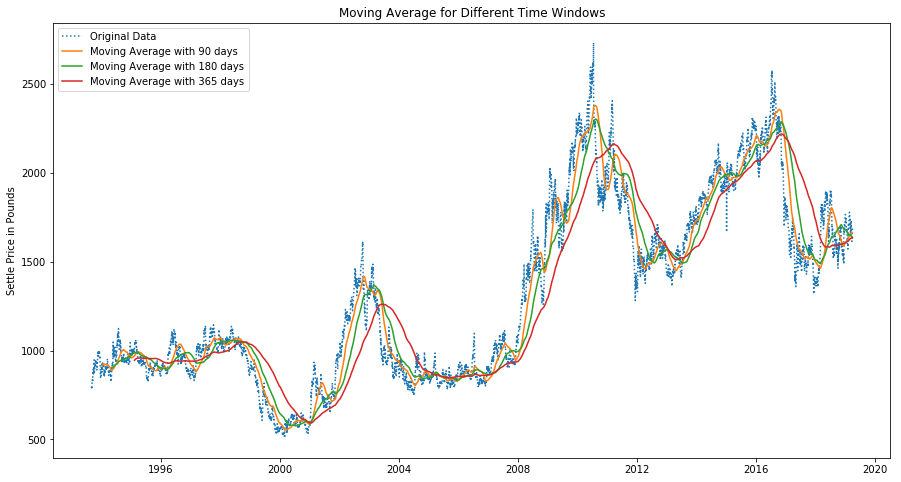

In [451]:
plt.title("Moving Average for Different Time Windows")
plt.plot(df["Settle"], linestyle=":", label="Original Data")
plt.plot(moving_avg_90days, label="Moving Average with 90 days")
plt.plot(moving_avg_180days, label="Moving Average with 180 days")
plt.plot(moving_avg_365days, label="Moving Average with 365 days")
plt.ylabel("Settle Price in Pounds")
plt.legend();

## Subtracting the Moving Average from the Time Series

Now we calculate the difference of the data points to the moving average for the three cases previously calculated.

In [338]:
moving_avg_90days_diff = df["Settle"] - moving_avg_90days
moving_avg_90days_diff.dropna(inplace=True)
moving_avg_180days_diff = df["Settle"] - moving_avg_180days
moving_avg_180days_diff.dropna(inplace=True)
moving_avg_365days_diff = df["Settle"] - moving_avg_365days
moving_avg_365days_diff.dropna(inplace=True)

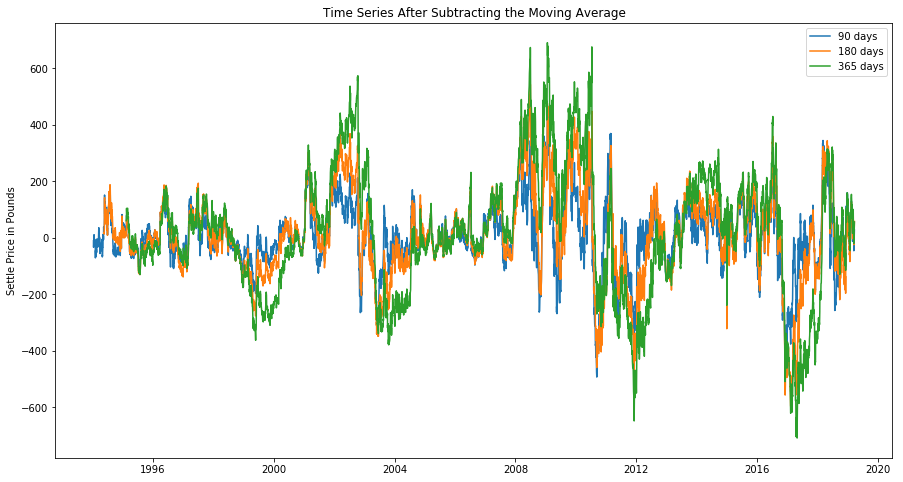

In [452]:
plt.title("Time Series After Subtracting the Moving Average")
plt.plot(moving_avg_90days_diff, label="90 days")
plt.plot(moving_avg_180days_diff, label="180 days")
plt.plot(moving_avg_365days_diff, label="365 days")
plt.ylabel("Settle Price in Pounds")
plt.legend();

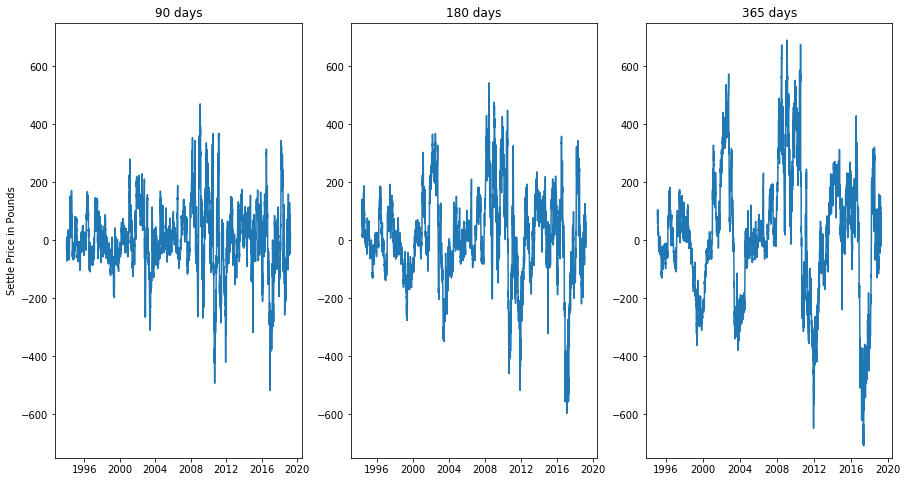

In [454]:
plt.subplot(1, 3, 1)
plt.plot(moving_avg_90days_diff, label="90 days")
for i in range(len(date_range)-1):
    df.loc[date_range[i]:date_range[i+1], "Quaterly Mean Settle Price"] = \
        df.loc[date_range[i]:date_range[i+1], "Settle"].mean()
plt.title("90 days")
plt.ylabel("Settle Price in Pounds")
plt.ylim(-750, 750)
plt.subplot(1, 3, 2)
plt.plot(moving_avg_180days_diff, label="180 days")
plt.title("180 days")
plt.ylim(-750, 750)
plt.subplot(1, 3, 3)
plt.plot(moving_avg_365days_diff, label="365 days")
plt.title("365 days")
plt.ylim(-750, 750);

## Subtracting the Moving Average Again

For the sake of curiosity, let's reapply the moving average again to the data,

In [367]:
moving_avg2_90days = moving_avg_90days_diff.rolling(90).mean()
moving_avg2_180days = moving_avg_180days_diff.rolling(180).mean()
moving_avg2_365days = moving_avg_365days_diff.rolling(365).mean()

In [368]:
moving_avg_90days_diff2 = moving_avg_90days_diff - moving_avg2_90days
moving_avg_90days_diff2.dropna(inplace=True)
moving_avg_180days_diff2 = moving_avg_180days_diff - moving_avg2_180days
moving_avg_180days_diff2.dropna(inplace=True)
moving_avg_365days_diff2 = moving_avg_365days_diff - moving_avg2_365days
moving_avg_365days_diff2.dropna(inplace=True)

# Defining a Function for Checking Stationarity and Checking it

In [14]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(365).mean()
    rolstd = timeseries.rolling(365).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='C0',label='Original')
    mean = plt.plot(rolmean, color='C3', label='Rolling Mean')
    std = plt.plot(rolstd, color='C2', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel("Settle Price in Pounds")
    plt.xlabel("Date")
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## Checking in the Original Data

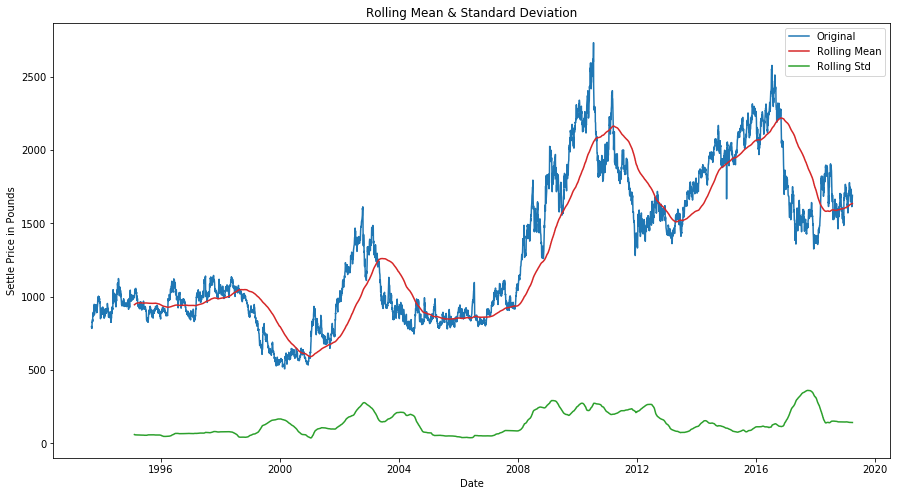

Results of Dickey-Fuller Test:
Test Statistic                   -1.945717
p-value                           0.310869
#Lags Used                        0.000000
Number of Observations Used    6588.000000
Critical Value (1%)              -3.431343
Critical Value (5%)              -2.861979
Critical Value (10%)             -2.567004
dtype: float64


In [459]:
test_stationarity(df["Settle"].dropna())

As expected, the `p-value` is greater than 5%, soon the original data is non-stationary.

## Checking after Subtraction of the 90-day Moving Average

### Moving Average Subtracted Once

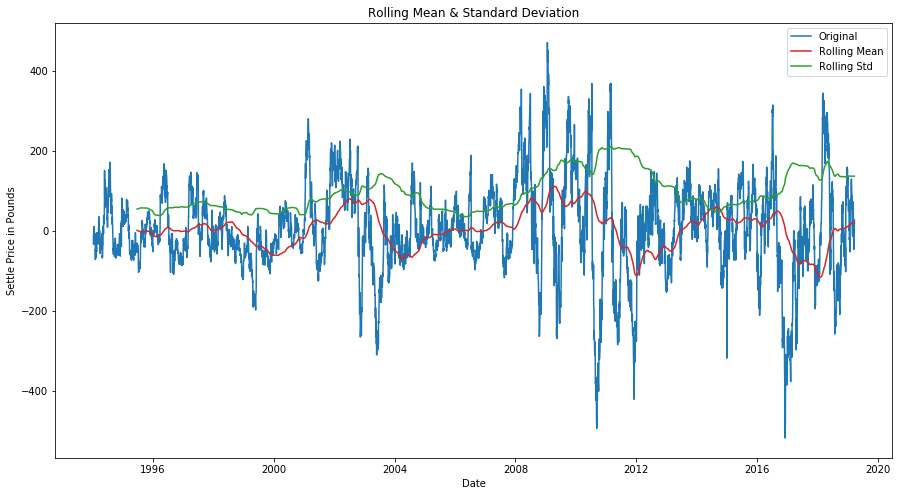

Results of Dickey-Fuller Test:
Test Statistic                -8.523435e+00
p-value                        1.085084e-13
#Lags Used                     7.000000e+00
Number of Observations Used    6.492000e+03
Critical Value (1%)           -3.431358e+00
Critical Value (5%)           -2.861985e+00
Critical Value (10%)          -2.567007e+00
dtype: float64


In [460]:
test_stationarity(moving_avg_90days_diff)

The `p-value` in this case is significantly less than 5%. Thus we can consider the data, after differing it, stationary.

### Moving Average Subtracted Twice

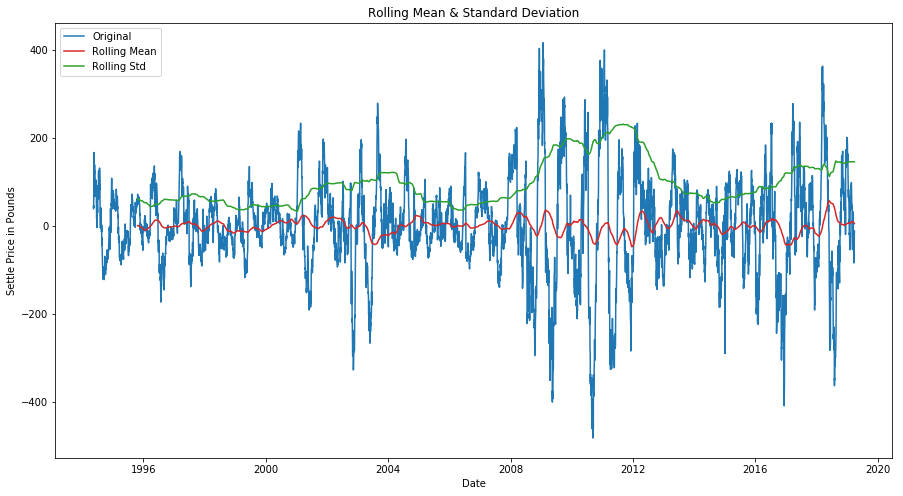

Results of Dickey-Fuller Test:
Test Statistic                -1.121550e+01
p-value                        2.074599e-20
#Lags Used                     3.100000e+01
Number of Observations Used    6.379000e+03
Critical Value (1%)           -3.431376e+00
Critical Value (5%)           -2.861993e+00
Critical Value (10%)          -2.567011e+00
dtype: float64


In [461]:
test_stationarity(moving_avg_90days_diff2)

The `p-value` is even smaller in this case.

## Checking after Subtraction of the 180-day Moving Average

### Moving Average Subtracted Once

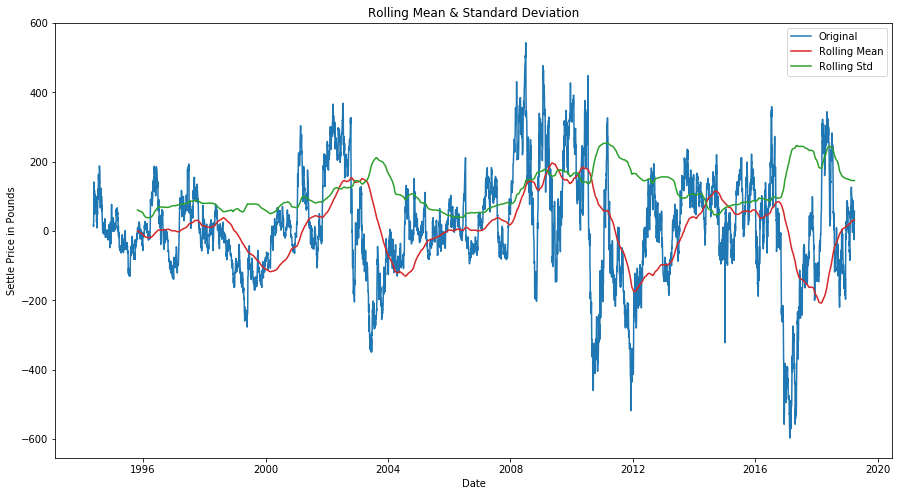

Results of Dickey-Fuller Test:
Test Statistic                -6.072808e+00
p-value                        1.140110e-07
#Lags Used                     0.000000e+00
Number of Observations Used    6.409000e+03
Critical Value (1%)           -3.431371e+00
Critical Value (5%)           -2.861991e+00
Critical Value (10%)          -2.567010e+00
dtype: float64


In [462]:
test_stationarity(moving_avg_180days_diff)

### Moving Average Subtracted Twice

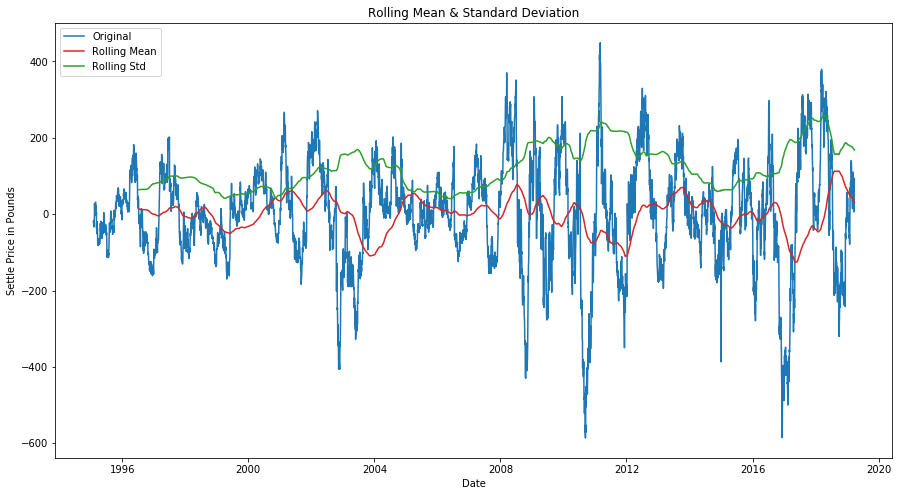

Results of Dickey-Fuller Test:
Test Statistic                -6.688355e+00
p-value                        4.170259e-09
#Lags Used                     0.000000e+00
Number of Observations Used    6.230000e+03
Critical Value (1%)           -3.431400e+00
Critical Value (5%)           -2.862004e+00
Critical Value (10%)          -2.567017e+00
dtype: float64


In [463]:
test_stationarity(moving_avg_180days_diff2)

## Checking after Subtraction the 365-day Moving Average

### Moving Average Subtracted Once

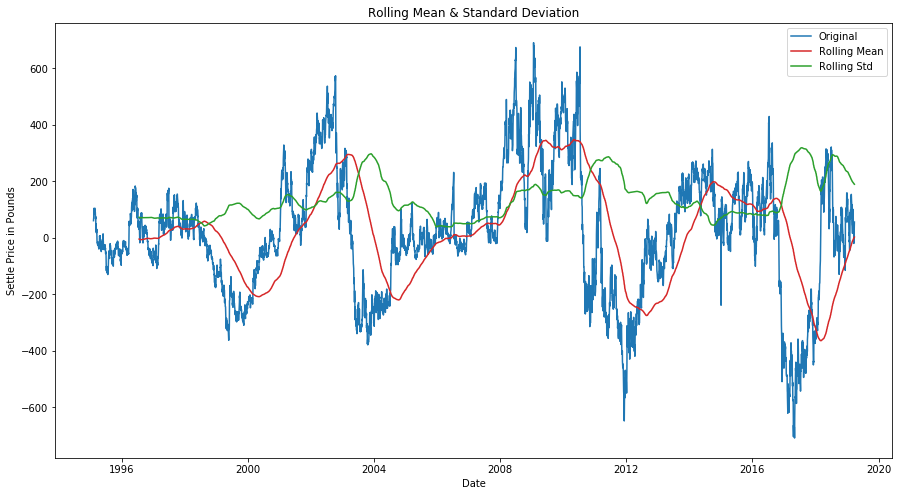

Results of Dickey-Fuller Test:
Test Statistic                   -4.179106
p-value                           0.000715
#Lags Used                        0.000000
Number of Observations Used    6224.000000
Critical Value (1%)              -3.431401
Critical Value (5%)              -2.862004
Critical Value (10%)             -2.567017
dtype: float64


In [464]:
test_stationarity(moving_avg_365days_diff)

### Moving Average Subtracted Twice

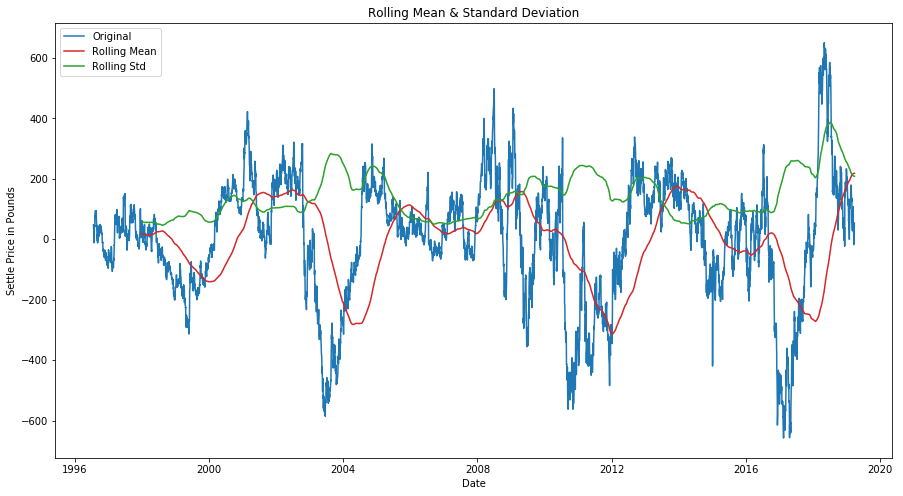

Results of Dickey-Fuller Test:
Test Statistic                   -4.502484
p-value                           0.000195
#Lags Used                        0.000000
Number of Observations Used    5860.000000
Critical Value (1%)              -3.431466
Critical Value (5%)              -2.862033
Critical Value (10%)             -2.567033
dtype: float64


In [465]:
test_stationarity(moving_avg_365days_diff2)

# Differencing

We continue our journey to make the time series stationary. Now let's try a different approach: differencing where from each time point is subtracted the previous time point. For this, we use the method [shift](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html).

## In the Original Data 

In [56]:
ts_diff = df["Settle"] - df["Settle"].shift()
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff);

NameError: name 'test_stationarity' is not defined

Now the time series in stationary, we check that in the previous plot and by the `p-value` being smaller than 5%.

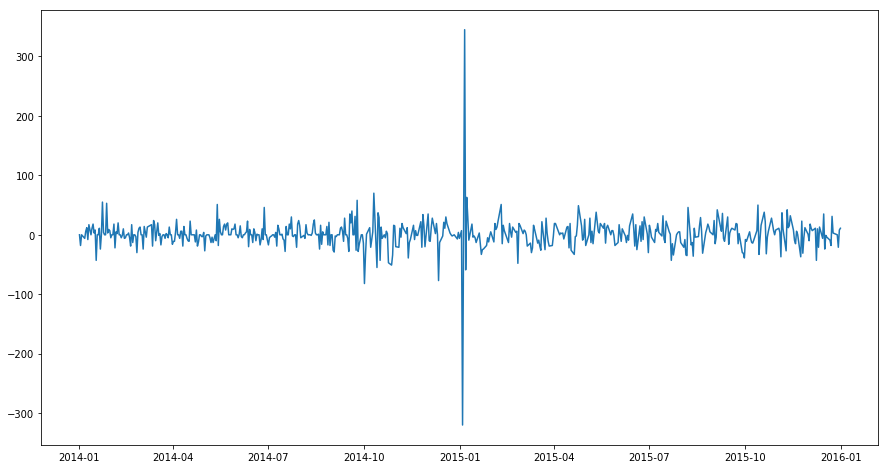

In [103]:
plt.plot(ts_diff[(ts_diff.index.year >= 2014) & (ts_diff.index.year <= 2015)]);

## Check Autocorrelation

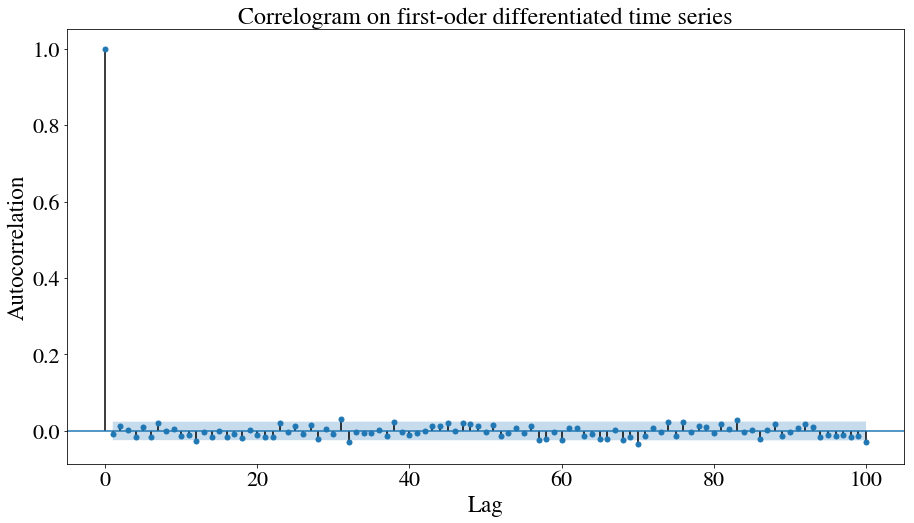

In [60]:
plot_acf(ts_diff, lags=100)
plt.title("Correlogram on first-oder differentiated time series")
plt.ylabel("Autocorrelation")
plt.xlabel("Lag");

The fact that only lag 0 presented significant correlation provides good evidence for modelling the residuals as a random walk, given by the following equation:
\begin{align}
x_t = x_{t-1} + w_t \\
\end{align}
where $w_t$ is a white noise series.

# Forecasting the Time Series

## Naive Forecast

In [73]:
# split into training and testing data
split_factor = 0.7
settle_series = df["Settle"].dropna()
train_max_idx = int(len(settle_series)*split_factor)
train_data = settle_series[:train_max_idx]
test_data = settle_series[train_max_idx:]

# predict for the test data
predictions = []
history = train_data[-1]
for i in range(len(test_data)): # TODO: same logic but no loop
    # assign to the predicted value the previous value (naive forecast)
    predictions.append(history)
    # store the current value for the next iteration
    history = test_data[i]
mse = mean_squared_error(test_data, predictions)
print("The MSE for the Naive Forecast is {:.4f}.".format(mse))

The MSE for the Naive Forecast is 719.7122.


**DONT DELETE THE CELL BELLOW**

In [389]:
lag_acf = acf(ts_diff, nlags=40)
lag_pacf = pacf(ts_diff, nlags=40, method='ols')

## Plot ACF and PACF

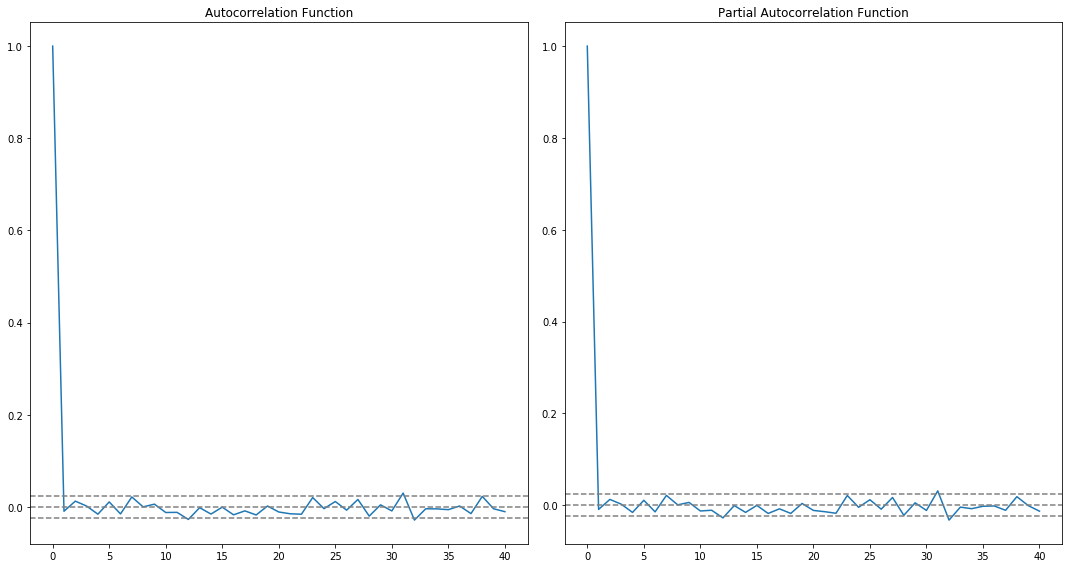

In [390]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout();

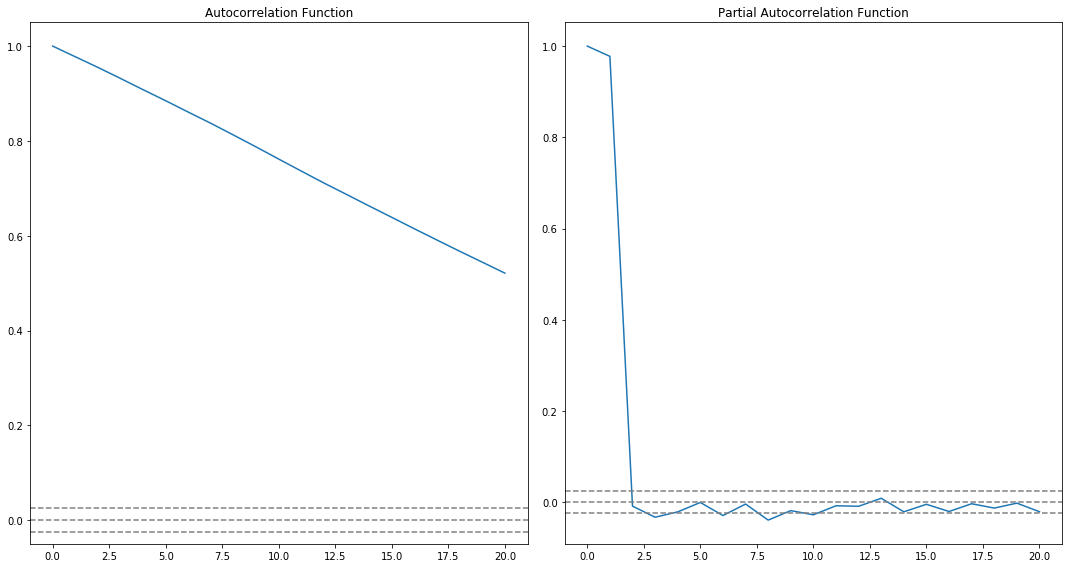

In [393]:
lag_acf = acf(moving_avg_90days_diff2, nlags=20)
lag_pacf = pacf(moving_avg_90days_diff2, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(moving_avg_90days_diff2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(moving_avg_90days_diff2)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(moving_avg_90days_diff2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(moving_avg_90days_diff2)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout();

## AR and ARIMA Model

### Applied to ts_diff (data obtained after differing)

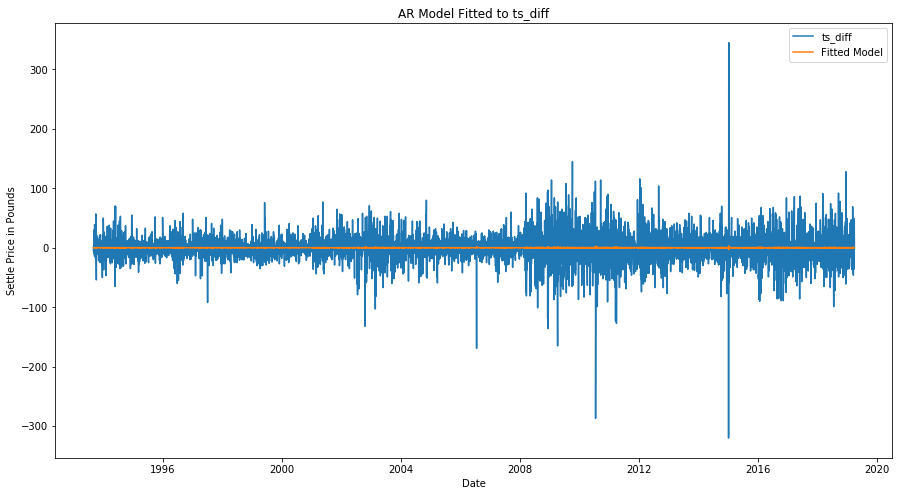

In [488]:
model = ARIMA(ts_diff, order=(1, 0, 0))
results_AR = model.fit(disp=1)
plt.title("AR Model Fitted to ts_diff")
plt.plot(ts_diff, label="ts_diff")
plt.plot(results_AR.fittedvalues, label="Fitted Model")
plt.ylabel("Settle Price in Pounds")
plt.xlabel("Date")
plt.legend();

### Applied to moving_avg_90days_diff2 (data obtained after subtracting the moving average twice)

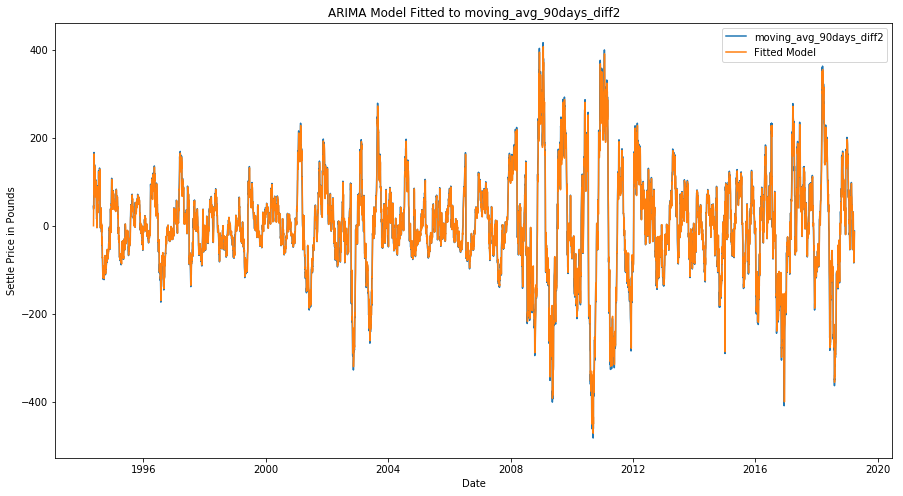

In [489]:
model = ARIMA(moving_avg_90days_diff2, order=(1, 0, 1))
results_ARIMA = model.fit(disp=1)
plt.title("ARIMA Model Fitted to moving_avg_90days_diff2")
plt.plot(moving_avg_90days_diff2, label="moving_avg_90days_diff2")
plt.plot(results_ARIMA.fittedvalues, label="Fitted Model")
plt.ylabel("Settle Price in Pounds")
plt.xlabel("Date")
plt.legend();

# Decomposition

Finally let's try rapidly a decompostion in the raw data. First using a 90-day frequency.

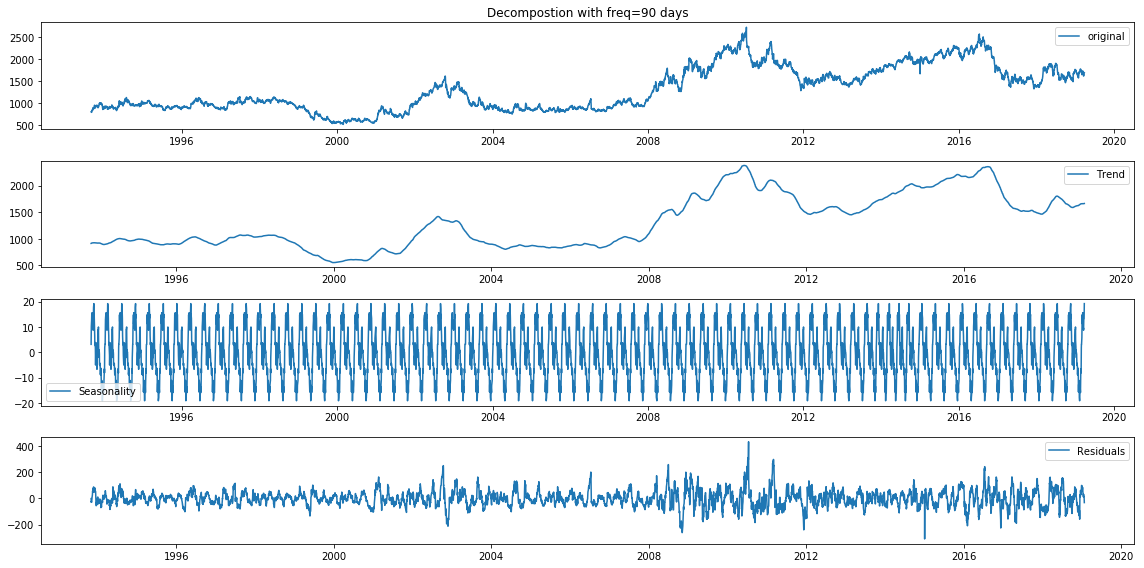

In [486]:
decomposition = seasonal_decompose(df["Settle"].dropna(), freq=90)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,8))
plt.subplot(411)
plt.title("Decompostion with freq=90 days")
plt.plot(df["Settle"].dropna(), label="original")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Now we use 365-day frequency.

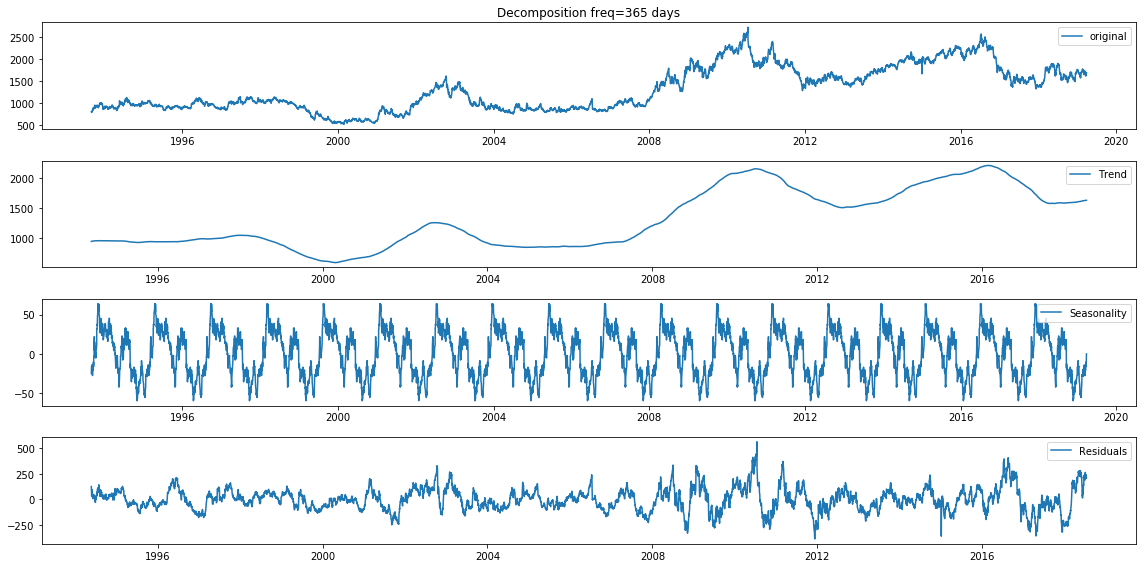

In [491]:
decomposition = seasonal_decompose(df["Settle"].dropna(), freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,8))
plt.subplot(411)
plt.title("Decomposition freq=365 days")
plt.plot(df["Settle"].dropna(), label="original")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Resources

This notebook was based on the following resources:

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/